# Computer Vision Confidence Calibration

## Introduction
In the world of computer vision, and machine learning in general, confidence scores are an often missunderstood value. Many folks, both practictioners and project stakeholders in general, assume that a model's confidence score directly reflects the probability of correctness. However, this is only true if the model is well-calibrated.

In real-world scenarios, particularly those of importance with high criticality, the likelihood of correctness is almost just as important as an accurate model prediction. Why? Because backend systems—whether it’s a database deciding what to store, or an API triggering an action—make binary decisions. Models give probabilities. Calibration is what lets a system draw a clean line between “trust this” and “maybe don’t". If your computer vision or ML system doesn’t report confidence, or reports uncalibrated scores, you’re either leaving performance on the table, or the system itself is unimportant.

In this demo, we'll first cover four ways to evaluate a model's calibration, and then we'll compare four confidence calibration improvemente techniques.

## Set Up - Dataset
For this demo, the set up is relatively simple. First we'll get a few pip packages installed and then get our [License Plate Recognition dataset](https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/1) from roboflow universe. If you're not familiar with roboflow, the platform makes working with datasets of all types incredibly easy.

In [ ]:
# Install pip packages
!pip install roboflow
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 8.0 MB/s eta 0:00:00


#### Because of conflicting package installations you'll need to start the environment

In [ ]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import numpy as np
from PIL import Image
import roboflow
import os
import matplotlib.pyplot as plt
from inference import get_model
import supervision as sv
from PIL import Image
from sklearn.isotonic import IsotonicRegression
import cv2
import pandas as pd
from scipy.stats import beta


In [ ]:
# Set constant working directory and create dataset directory
HOME = os.getcwd()
print(HOME)
!mkdir {HOME}/datasets
%cd {HOME}/datasets

/content
/content/datasets


In [ ]:
# Autheticate with roboflow (you must already have a free account)
roboflow.login()
rf = roboflow.Roboflow()

# Download the dataset from roboflow universe
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(1)
dataset = version.download("yolov8")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-1 in yolov8:: 100%|██████████| 20264/20264 [00:02<00:00, 6871.05it/s]


## Set Up - Inference
For the second part of setup, we'll load the model from roboflow universe. NOTE: you will need to paste your API key here. Then we'll run the test set through the model recording for each image the ground truth, and the model's predictions.

Then we'll iterate through test and train datasets and get the predictions and confidences for each. The train set will be used to train post-hoc confidence calibration models.

In [ ]:
# Load model
model = get_model("license-plate-recognition-rxg4e/2", api_key="YOURAPIKEY")

In [ ]:
def get_predictions_and_targets(dataset_location, split, model, max_images=None):
    """
    Performs inference on a dataset split and returns image paths, predictions, and target labels.

    Args:
        dataset_location (str): Path to the dataset directory.
        split (str): The dataset split to use ('train', 'valid', or 'test').
        model: The loaded inference model.
        max_images (int, optional): Maximum number of images to process. Defaults to None.

    Returns:
        tuple: A tuple containing three lists:
               - image_paths (list): List of image file paths.
               - predictions_list (list): List of sv.Detections objects for predictions.
               - targets_list (list): List of sv.Detections objects for ground truth labels.
    """
    image_paths = []
    predictions_list = []
    targets_list = []

    # Load the specific split dataset
    split_dataset = sv.DetectionDataset.from_yolo(
        images_directory_path=f"{dataset_location}/{split}/images",
        annotations_directory_path=f"{dataset_location}/{split}/labels",
        data_yaml_path=f"{dataset_location}/data.yaml"
    )

    temp_count = 0
    for image_path, image, label in split_dataset:
        if max_images is not None and temp_count >= max_images:
            break

        # The 'image' object from sv.DetectionDataset might be a NumPy array or PIL Image.
        # Ensure it's in a format `model.infer` can handle. Assuming PIL Image is preferred.
        if isinstance(image, np.ndarray):
             image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
             image_pil = image # Assume it's already a compatible format (like PIL)

        result = model.infer(image_pil)[0]
        predictions = sv.Detections.from_inference(result)

        image_paths.append(image_path)
        predictions_list.append(predictions)
        targets_list.append(label) # label is already sv.Detections

        temp_count += 1

    return image_paths, predictions_list, targets_list

#### This will take a minute

In [ ]:
# For each image in the test set, do inference and save the prediction and ground truth for eval
test_image_paths, test_predictions_list, test_targets_list = get_predictions_and_targets(
    dataset.location, "test", model, max_images=4000
)

# For each image in the train set, do inference and save the prediction and ground truth for eval
train_image_paths, train_predictions_list, train_targets_list = get_predictions_and_targets(
    dataset.location, "train", model
)

### Helper Functions
Now that we have our ground truth and predictions, we need to evaluate each predictions correctness, and get format our results so they're ready for confidence calibration analysis.

First we define a function, compute_iou, that computes the intersection over union (iou) for two bounding boxes which we'll use later to evaluate the correctness of a given detection. NOTE: it is best practice to use industry standard evaluation libraries instead of implementing your own like I am doing in this demo. Then we define a function that uses the compute_iou function to evaluate the output of our inference results. From there we get the correctness of each prediction, and its confidence, the two parts we need to evaluate calibration.




In [ ]:
def compute_iou(boxA, boxB):
    """
    Compute IoU between two bounding boxes.
    Each box is [x1, y1, x2, y2]
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea

def prepare_calibration_data(predictions_list, targets_list, iou_threshold=0.5):
    """
    Prepares (confidence, correctness) pairs for calibration metrics from object detection results.

    Args:
        predictions_list: list of sv.Detections (model outputs)
        targets_list: list of sv.Detections (ground-truth)
        iou_threshold: IoU threshold to consider a match

    Returns:
        confidences: np.array of prediction confidence scores
        correctness: np.array of binary correctness (1 for correct, 0 for incorrect)
    """
    confidences = []
    correctness = []

    for preds, targets in zip(predictions_list, targets_list):
        if len(preds.xyxy) == 0:
            continue

        for i, pred_box in enumerate(preds.xyxy):
            pred_class = preds.class_id[i]
            pred_conf = preds.confidence[i]
            matched = False

            for j, target_box in enumerate(targets.xyxy):
                target_class = targets.class_id[j]
                if pred_class != target_class:
                    continue

                iou = compute_iou(pred_box, target_box)
                if iou >= iou_threshold:
                    matched = True
                    break

            confidences.append(pred_conf)
            correctness.append(1 if matched else 0)

    return np.array(confidences), np.array(correctness)

In [ ]:
test_confidences, test_correctness = prepare_calibration_data(test_predictions_list, test_targets_list, iou_threshold=0.5)
train_confidences, train_correctness = prepare_calibration_data(train_predictions_list, train_targets_list, iou_threshold=0.5)

## Evaluating Confidence Calibration

#### Reliability Diagrams
The most LinkedIn-influencer-friendly way to measure a model’s confidence calibration is the **Reliability Diagram**. Predictions from the model are sorted into bins along the x-axis based on their confidence scores, and the accuracy of each bin is then calculated and plotted on the y-axis. A **perfectly calibrated** model will produce a reliability diagram that follows a 1:1 slope (a diagonal line from the origin to the top-right corner).

In [ ]:
def plot_reliability_diagram(confidences, correctness, n_bins=10):
    """
    Plot a reliability diagram using prediction confidences and binary correctness.

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (0-1)
        correctness (np.ndarray): Array of binary values (1 if correct, 0 if not)
        n_bins (int): Number of bins to group confidence values
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    accs = []
    confs = []

    for i in range(n_bins):
        mask = (confidences >= bins[i]) & (confidences < bins[i+1])
        bin_correct = correctness[mask]
        bin_conf = confidences[mask]

        if len(bin_correct) > 0:
            acc = np.mean(bin_correct)
            conf = np.mean(bin_conf)
        else:
            acc = 0.0
            conf = 0.0

        accs.append(acc)
        confs.append(conf)

    accs = np.array(accs)
    confs = np.array(confs)
    gaps = confs - accs

    # Plot bars
    bar_width = 1.0 / n_bins
    plt.bar(bin_centers, accs, width=bar_width, edgecolor='black', label='Accuracy', color='skyblue')
    plt.bar(bin_centers, gaps, bottom=accs, width=bar_width, edgecolor='black', color='red', alpha=0.6, label='Gap')

    # Perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

#### Expected Calibration Error (ECE)
ECE measures how well a model’s predicted confidence scores align with actual accuracy. It works by grouping predictions into bins based on confidence levels, then calculating the average difference between each bin’s confidence and observed accuracy. A lower ECE indicates better calibration.

In [ ]:
def calculate_ece(confidences, correctness, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE).

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (0-1).
        correctness (np.ndarray): Array of binary values (1 if correct, 0 if incorrect).
        n_bins (int): Number of bins to group confidence values.

    Returns:
        float: Expected Calibration Error (ECE)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    n = len(confidences)

    for i in range(n_bins):
        bin_lower = bins[i]
        bin_upper = bins[i + 1]
        mask = (confidences >= bin_lower) & (confidences < bin_upper)

        bin_conf = confidences[mask]
        bin_correct = correctness[mask]
        bin_size = len(bin_conf)

        if bin_size > 0:
            avg_conf = np.mean(bin_conf)
            avg_acc = np.mean(bin_correct)
            bin_ece = np.abs(avg_conf - avg_acc) * (bin_size / n)
            ece += bin_ece

    return ece

#### Maximum Calibration Error (MCE)

MCE captures the worst-case gap between predicted confidence and actual accuracy across all bins. Like ECE, it groups predictions into confidence bins, but instead of averaging, it reports the **maximum** observed gap—identifying the single most miscalibrated region of the model’s output.

In [ ]:
def calculate_mce(confidences, correctness, n_bins=10):
    """
    Calculate Maximum Calibration Error (MCE).

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (0-1).
        correctness (np.ndarray): Array of binary values (1 if correct, 0 if incorrect).
        n_bins (int): Number of bins to group confidence values.

    Returns:
        float: Maximum Calibration Error (MCE)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    mce = 0.0

    for i in range(n_bins):
        bin_lower = bins[i]
        bin_upper = bins[i + 1]
        mask = (confidences >= bin_lower) & (confidences < bin_upper)

        bin_conf = confidences[mask]
        bin_correct = correctness[mask]

        if len(bin_conf) > 0:
            avg_conf = np.mean(bin_conf)
            avg_acc = np.mean(bin_correct)
            gap = np.abs(avg_conf - avg_acc)
            mce = max(mce, gap)

    return mce

#### Brier Score
The Brier Score quantifies the mean squared difference between predicted confidence and actual binary outcomes. A lower Brier Score indicates better-calibrated AND more accurate predictions.

Unlike ECE or MCE, which focus purely on calibration, Brier Score blends both **calibration** and **discrimination**. This makes it a more holistic metric in some cases, but also harder to interpret in isolation. I like to think of it as the L2 loss of a model’s confidence output.

In [ ]:
def calculate_brier_score(confidences, correctness):
    """
    Calculate Brier Score.

    Args:
        confidences (np.ndarray): Array of predicted confidence scores (0-1).
        correctness (np.ndarray): Array of binary values (1 if correct, 0 if incorrect).

    Returns:
        float: Brier Score
    """
    confidences = np.asarray(confidences)
    correctness = np.asarray(correctness)
    return np.mean((confidences - correctness) ** 2)

In [ ]:
results = []

### Running the Evaluation Methods on Raw Confidences
Next we'll run each of the four confidence calibration methods on the confidences and predictions made by the model on our test set

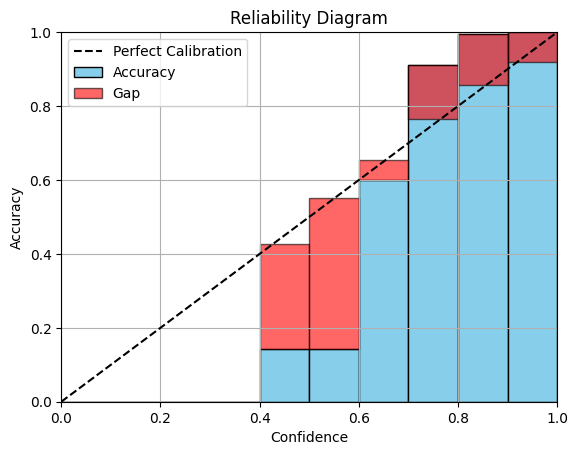

ECE: 0.12552337626616158
MCE: 0.407440756048475
Brier Score: 0.02931204679346779


In [ ]:
plot_reliability_diagram(test_confidences, test_correctness, n_bins=10)
ece = calculate_ece(test_confidences, test_correctness, n_bins=10)
mce = calculate_mce(test_confidences, test_correctness, n_bins=10)
brier = calculate_brier_score(test_confidences, test_correctness)

print(f'ECE: {ece}')
print(f'MCE: {mce}')
print(f'Brier Score: {brier}')
results.append(['raw', ece, mce, brier])

## Confidence Calibration Post-training Improvements

#### Isotonic Regression
Isotonic regression is a non-parametric method that fits a piecewise constant, non-decreasing function to map raw model confidences to calibrated probabilities. It performs well with large validation datasets but can overfit on small or noisy data. Think of it as a post-hoc inference. First your computer vision model does inference, and then this secondary model predicts actual confidence based on its training.


In [ ]:
def train_isotonic_calibrator(train_confidences: np.ndarray, train_correctness: np.ndarray) -> IsotonicRegression:
    """
    Trains an isotonic regression model for calibration.

    Args:
        train_confidences: array of model confidence scores from training/validation set
        train_correctness: array of binary correctness labels (1 for correct, 0 for incorrect)

    Returns:
        iso_model: trained IsotonicRegression model
    """
    iso_model = IsotonicRegression(out_of_bounds='clip')
    iso_model.fit(train_confidences, train_correctness)
    return iso_model


In [ ]:
# Fit isotonic regression model
iso_model = train_isotonic_calibrator(train_confidences, train_correctness)
# Use model to calibrate test confidences
iso_calibrated_confidences = iso_model.predict(test_confidences)

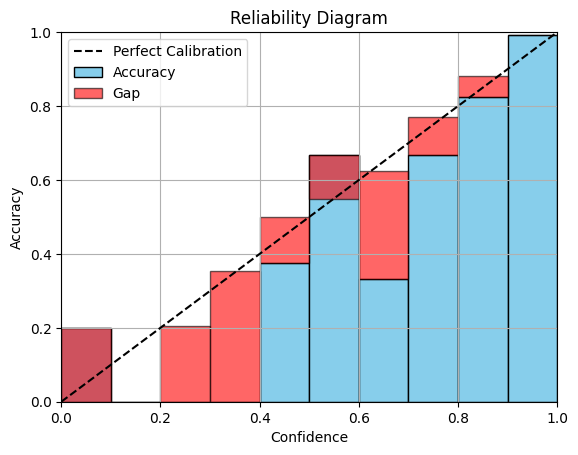

ECE: 0.006801748294699351
MCE: 0.35294117647058826
Brier Score: 0.01308171067307804


In [ ]:
plot_reliability_diagram(iso_calibrated_confidences, test_correctness, n_bins=10)
iso_ece = calculate_ece(iso_calibrated_confidences, test_correctness, n_bins=10)
iso_mce = calculate_mce(iso_calibrated_confidences, test_correctness, n_bins=10)
iso_brier = calculate_brier_score(iso_calibrated_confidences, test_correctness)

print(f'ECE: {iso_ece}')
print(f'MCE: {iso_mce}')
print(f'Brier Score: {iso_brier}')
results.append(['isotonic', iso_ece, iso_mce, iso_brier])

#### Histogram Binning
Histogram binning divides predictions into fixed-width confidence intervals and assigns the average accuracy of each bin to the predictions within it. It's simple and interpretable but sensitive to the number and placement of bins.


In [ ]:
def train_histogram_binning(train_confidences: np.ndarray, train_correctness: np.ndarray, n_bins: int = 10):
    """
    Trains a histogram-binning calibration model.

    Args:
        train_confidences: array of model confidence scores from training/validation set
        train_correctness: array of binary correctness labels (1 for correct, 0 for incorrect)
        n_bins: number of bins to discretize the confidence range [0,1]

    Returns:
        bin_edges: array of bin edges
        bin_accs: array of calibrated probabilities per bin
    """
    # Create equally spaced bins
    bin_edges = np.linspace(0, 1, n_bins + 1)

    # Initialize array to hold the average correctness per bin
    bin_accs = np.zeros(n_bins)

    # Digitize confidences into bins
    bin_ids = np.digitize(train_confidences, bin_edges) - 1
    # Clip to valid indices (in case a value == 1 falls outside last bin)
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            bin_accs[i] = train_correctness[mask].mean()
        else:
            # fallback: use midpoint of bin if empty
            bin_accs[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

    return bin_edges, bin_accs

def apply_histogram_binning(bin_edges: np.ndarray, bin_accs: np.ndarray, test_confidences: np.ndarray):
  """
  Apply histogram-binning calibration to a set of test confidences.

  Args:
      bin_edges: array of bin edges returned by train_histogram_binning
      bin_accs: array of calibrated probabilities per bin returned by train_histogram_binning
      test_confidences: array of model confidence scores to calibrate

  Returns:
      calibrated_probs: array of calibrated probabilities
  """
  n_bins = len(bin_accs)

  # Digitize test confidences
  bin_ids = np.digitize(test_confidences, bin_edges) - 1
  bin_ids = np.clip(bin_ids, 0, n_bins - 1)  # handle edge cases

  # Map each confidence to its calibrated probability
  calibrated_probs = bin_accs[bin_ids]

  return calibrated_probs


In [ ]:
histo_calibrator = train_histogram_binning(train_confidences, train_correctness, n_bins=10)
histo_calibrated_confidences = apply_histogram_binning(histo_calibrator[0], histo_calibrator[1], test_confidences)

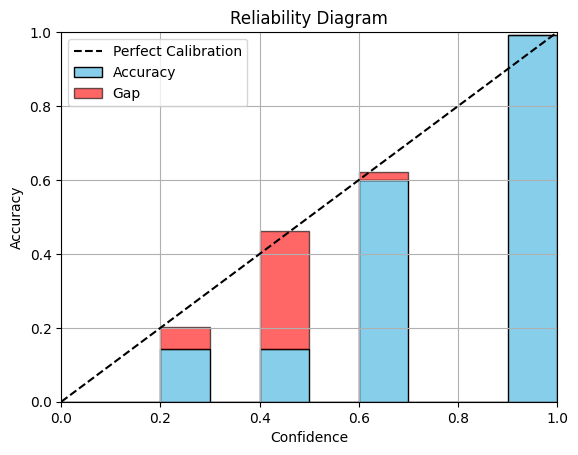

ECE: 0.0028617008017308046
MCE: 0.31868131868131877
Brier Score: 0.012969877382886375


In [ ]:
plot_reliability_diagram(histo_calibrated_confidences, test_correctness, n_bins=10)
histo_ece = calculate_ece(histo_calibrated_confidences, test_correctness, n_bins=10)
histo_mce = calculate_mce(histo_calibrated_confidences, test_correctness, n_bins=10)
histo_brier = calculate_brier_score(histo_calibrated_confidences, test_correctness)

print(f'ECE: {histo_ece}')
print(f'MCE: {histo_mce}')
print(f'Brier Score: {histo_brier}')

results.append(['histogram', histo_ece, histo_mce, histo_brier])

#### Bayesian Binning into Quantiles (BBQ)
I haven’t used this one in real projects—I just think the name BBQ is fun. BBQ takes histogram binning and adds a Bayesian twist, averaging over different ways to split up the data. This helps avoid overfitting and deals with uncertainty better, especially when you don’t have much data.


In [ ]:
class BayesianBinningCalibrator:
    def __init__(self, n_bins=10, alpha_prior=1.0, beta_prior=1.0):
        """
        Bayesian histogram binning calibration.

        Args:
            n_bins (int): Number of bins to discretize confidences into.
            alpha_prior (float): Beta prior alpha parameter.
            beta_prior (float): Beta prior beta parameter.
        """
        self.n_bins = n_bins
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        self.bins = None
        self.bin_posteriors = None  # list of (alpha, beta) tuples per bin

    def fit(self, confidences, correctness):
        """
        Fit the Bayesian bins using training confidences and correctness labels.

        Args:
            confidences (np.array): Prediction confidences (0-1)
            correctness (np.array): Binary correctness (0 or 1)
        """
        # Define bin edges
        self.bins = np.linspace(0, 1, self.n_bins + 1)
        self.bin_posteriors = []

        # Compute posterior Beta parameters for each bin
        for i in range(self.n_bins):
            mask = (confidences >= self.bins[i]) & (confidences < self.bins[i+1])
            correct_in_bin = np.sum(correctness[mask])
            incorrect_in_bin = np.sum(mask) - correct_in_bin

            alpha_post = self.alpha_prior + correct_in_bin
            beta_post = self.beta_prior + incorrect_in_bin

            self.bin_posteriors.append((alpha_post, beta_post))

    def predict(self, confidences, return_posterior=False):
        """
        Apply Bayesian binning to new confidences.

        Args:
            confidences (np.array): Array of predicted confidences
            return_posterior (bool): If True, return full Beta distributions
        Returns:
            np.array: Calibrated confidences
        """
        calibrated = np.zeros_like(confidences)
        posterior_distributions = []

        for idx, conf in enumerate(confidences):
            # Find bin
            bin_idx = np.searchsorted(self.bins, conf, side='right') - 1
            bin_idx = np.clip(bin_idx, 0, self.n_bins - 1)

            alpha_post, beta_post = self.bin_posteriors[bin_idx]
            posterior_distributions.append(beta(alpha_post, beta_post))

            # Calibrated probability = mean of Beta
            calibrated[idx] = alpha_post / (alpha_post + beta_post)

        if return_posterior:
            return calibrated, posterior_distributions
        return calibrated


In [ ]:
# Train BBQ calibrator
bbq = BayesianBinningCalibrator(n_bins=10, alpha_prior=1.0, beta_prior=1.0)
bbq.fit(train_confidences, train_correctness)

# Apply to test set
bbq_calibrated_test_confidences = bbq.predict(test_confidences)


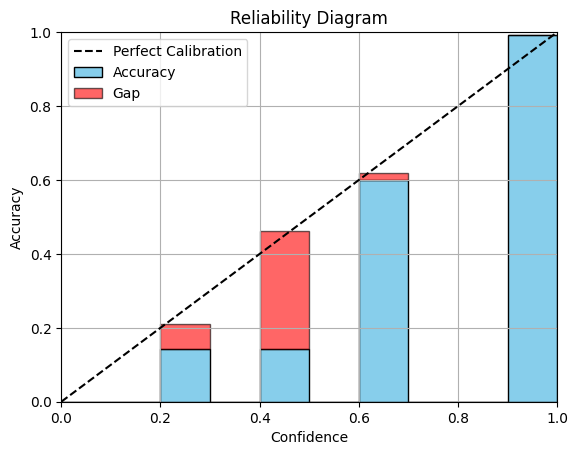

ECE: 0.003185031988079804
MCE: 0.31982942430703637
Brier Score: 0.012976547231977234


In [ ]:
plot_reliability_diagram(bbq_calibrated_test_confidences, test_correctness, n_bins=10)
bbq_ece = calculate_ece(bbq_calibrated_test_confidences, test_correctness, n_bins=10)
bbq_mce = calculate_mce(bbq_calibrated_test_confidences, test_correctness, n_bins=10)
bbq_brier = calculate_brier_score(bbq_calibrated_test_confidences, test_correctness)
print(f'ECE: {bbq_ece}')
print(f'MCE: {bbq_mce}')
print(f'Brier Score: {bbq_brier}')
results.append(['bbq', bbq_ece, bbq_mce, bbq_brier])

      method       ece       mce     brier
0        raw  0.125523  0.407441  0.029312
1   isotonic  0.006802  0.352941  0.013082
2  histogram  0.002862  0.318681  0.012970
3        bbq  0.003185  0.319829  0.012977


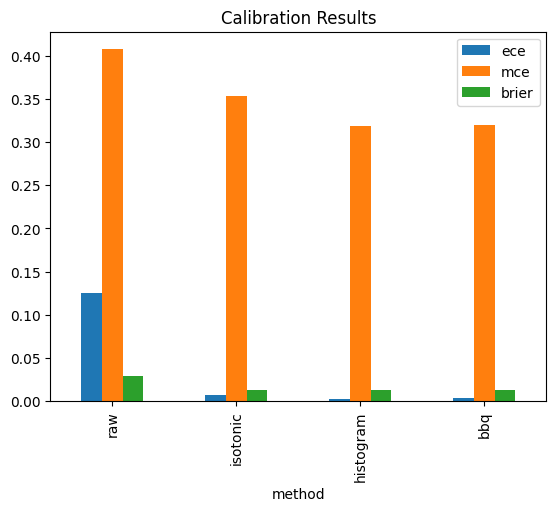

In [ ]:
results_df = pd.DataFrame(results, columns=['method', 'ece', 'mce', 'brier'])
# Create barchart of results
results_df.plot(x='method', y=['ece', 'mce', 'brier'], kind='bar', title='Calibration Results')
# Print the results in a table
print(results_df)

#### Conclusion
Any calibration technique is better than none. Also, in production, your customer will notice ECE every day, but MCE is what will stand out on the days things go wrong. As always, data science is a people industry, choose your metrics accordingly.